# Setup

In [1]:
import mercantile, mapbox_vector_tile, requests, json
from vt2geojson.tools import vt_bytes_to_geojson
import os
import json
import pandas as pd
import json
import shapely
import numpy as np

from mapboxgl.utils import *
from mapboxgl.viz import *

import functions
import imp
import ipyplot

import geopandas as gpd
from PIL import Image

import shapely

pd.set_option('display.precision', 2)

/var/folders/gr/y1k9q01d2zg0rgh45l5x98yw0000gp/T/ipykernel_2462/4028522993.py:14: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [68]:
df_coded = functions.get_df_coded()
print(len(df_coded), df_coded.useful.sum())

792 786


In [69]:
imp.reload(functions)
df_streets = functions.get_streets()

In [70]:
imp.reload(functions)
points = functions.nyc_borough_coordinates_shapely

borough = 'Queens'
name_start = 'Northwest_Tip'
name_end = 'Southeast_Corner'

point_start = points[borough][name_start]
point_end = points[borough][name_end]

tiles = functions.get_tiles(point_start, point_end)
print("Number of tiles: ", len(tiles))
functions.save_tiles(tiles)
print("Done saving tiles")

max_tiles = 200
# Take random sample of this size from tiles
i_sampled = np.random.choice(len(tiles), min(len(tiles), max_tiles), replace=False)
tiles_sampled = [t for (i,t) in enumerate(tiles) if i in i_sampled]

df_images = functions.load_images(tiles_sampled)
print("Number of images: ", len(df_images))

imp.reload(functions)

ls = shapely.LineString([point_start, point_end])
point_mid = gpd.GeoSeries([ls.interpolate(0.5, normalized=True)], crs=functions.crs_geo).to_crs(functions.crs).iloc[0]

df_streets['dist_mid'] = df_streets.geometry.apply(lambda p: p.distance(point_mid))
df_images['dist_mid'] = df_images.geometry.apply(lambda p: p.distance(point_mid))

outline = functions.outlines[borough]
def dist_to_outline(p):
    return p.distance(outline)

df_streets['dist_outline'] = df_streets.geometry.apply(dist_to_outline)
df_images['dist_outline'] = df_images.geometry.apply(dist_to_outline)

Number of tiles:  154
Done saving tiles
Number of images:  1575447


In [71]:
dist_mid = 4000000
dist_outline = 0

ds_start = '2017-01-01'

df_streets_small = (df_streets
                    .query(f'dist_mid <= {dist_mid}')
                    .query(f'dist_outline <= {dist_outline}')
                    .copy())

df_images_small = (df_images
                   .query('ds >= @ds_start')
                   .query('~ is_pano')
                   .query('~ is_coded')
                   .query(f'dist_mid <= {dist_mid}')
                   .query(f'dist_outline <= {dist_outline}')
                   .copy())

imp.reload(functions)
max_dist_meters = 200
df_streets_points = functions.explode_points(df_streets_small, max_dist_meters=max_dist_meters)
df_streets_points.set_geometry('point', inplace=True)
df_streets_points = df_streets_points
len(df_images_small), len(df_streets_small), len(df_streets_points)

(1196393, 4300, 30146)

<Axes: >

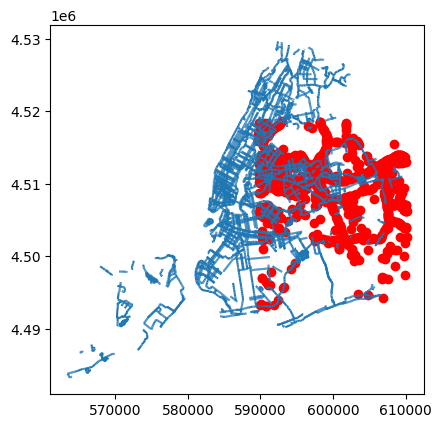

In [72]:
base = df_streets.plot()
df_images.sample(1000).plot(ax=base, color='red')

<Axes: >

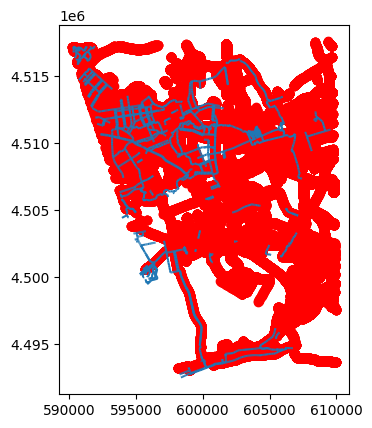

In [73]:
base = df_streets_small.plot()
df_images_small.plot(ax=base, color='red')

In [74]:
imp.reload(functions)
buffer_meters = 100
merged = functions.merge_multiple(df_streets_points, df_images_small, buffer_meters)

merged['dist_line'] = [ls.distance(p) for ls, p in zip(merged.line_string, merged.point_image)]
merged['min_dist_line_by_num_point'] = merged.groupby('linesegment_str').dist_line.transform('min')

renamer = {
    'id': 'id_image',
    'compass_angle': 'angle_image',
    'line_angle': 'angle_street'
    }

df = merged.rename(columns=renamer).query('dist_line <= 200').groupby('num_point').head(5).reset_index()
images_before_coding = df.id_image.nunique()

cols_key = ['id_image', 'num_point', 'angle_image', 'angle_street', 
            'distance_raw', 'distance_meters', 'time', 'segmentid', 'point', 'point_image']

images_before_coding, df.id_image.nunique(), len(df), df_streets_points.point.nunique(), df.point.nunique(), df.groupby('num_point').distance_meters.min().median()

/Users/cg/Dropbox/code/Python/bikemapillary/.venv/lib/python3.11/site-packages/shapely/measurement.py:74: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


(18325, 18325, 101800, 14915, 10117, 9.802408599451509)

In [75]:
# Find images as follows:
# Start with a random image from merged dataset
# Create a list of good candidates
# Drop if:
# - close to a point in the coded dataset
# - close to other candidates
# - angle is wrong
# Stop after N images

df_to_code = pd.DataFrame()
df_coded = pd.read_csv('data/bike_coding_sheet_download.csv')
ids_useful = list(df_coded.query('useful==1').id.unique().astype(int))
assert len(ids_useful) > 100
df_useful = df_images[df_images.id.isin(ids_useful)]

num_to_code = 600
dist_useful_cutoff = 100
dist_current_cutoff = 50
LARGE_NUMBER = 100000

removed_for_close_to_useful = 0
removed_for_close_to_coded = 0

num_scaler = 100

df['image_diff'] = np.abs(df.angle_image - df.angle_street) % 360
angle_cutoff = 30
df_take = df.query('image_diff <= @angle_cutoff').copy()
print(len(df), len(df_take))
df.set_geometry('point_image', inplace=True)

for i in range(num_to_code * num_scaler):
    if i % 500 == 0:
        # Print the df size and all removal numbers in a nice format
        print(f"i: {i:4d} | df size: {len(df_to_code):4d} | useful: {removed_for_close_to_useful:4d} | in current data: {removed_for_close_to_coded:4d}")
    if len(df_to_code) >= num_to_code:
        print(f"Went through {i} iterations")
        break

    if df_to_code.shape[0] >= 1:
        df_to_code.set_geometry('point_image', inplace=True)

    row_to_code = df_take.sample(1).iloc[0]
    

    if len(df_useful) > 0:
        dist_useful = df_useful.geometry.apply(lambda p: p.distance(row_to_code.point_image)).min()
        if dist_useful < dist_useful_cutoff:
            removed_for_close_to_useful += 1
            continue

    dist_coded = LARGE_NUMBER if len(df_to_code)==0 else df_to_code.geometry.apply(lambda p: p.distance(row_to_code.point_image)).min()
    if dist_coded < dist_current_cutoff:
        removed_for_close_to_coded += 1
        continue

    df_new = pd.DataFrame([row_to_code])
    df_to_code = pd.concat([df_to_code, df_new])
    df_to_code = gpd.GeoDataFrame(df_to_code)

len(df), len(df_to_code), df_to_code.id_image.duplicated().sum()

101800 26593
i:    0 | df size:    0 | useful:    0 | in current data:    0
i:  500 | df size:  143 | useful:  218 | in current data:  139
i: 1000 | df size:  226 | useful:  451 | in current data:  323
i: 1500 | df size:  287 | useful:  669 | in current data:  544
i: 2000 | df size:  338 | useful:  892 | in current data:  770
i: 2500 | df size:  377 | useful: 1112 | in current data: 1011
i: 3000 | df size:  407 | useful: 1353 | in current data: 1240
i: 3500 | df size:  438 | useful: 1556 | in current data: 1506
i: 4000 | df size:  461 | useful: 1774 | in current data: 1765
i: 4500 | df size:  484 | useful: 2021 | in current data: 1995
i: 5000 | df size:  501 | useful: 2222 | in current data: 2277
i: 5500 | df size:  519 | useful: 2452 | in current data: 2529
i: 6000 | df size:  530 | useful: 2675 | in current data: 2795
i: 6500 | df size:  540 | useful: 2896 | in current data: 3064
i: 7000 | df size:  553 | useful: 3122 | in current data: 3325
i: 7500 | df size:  564 | useful: 3338 | i

(101800, 600, 0)

In [76]:
imp.reload(functions)

num_max = 600

with open('/Users/cg/temp2/mapillary_token', 'r') as f:
    token = f.read().strip()
    functions.access_token_mapillary = token

num_saved = 0
for i, (_, feature) in enumerate(df_to_code.iterrows()):
    if i % 20 == 0:
        print(f"{i:3d}")
    # Stop the iteration after num_max
    if i >= num_max:
        break

    image_id = feature['id_image']
    
    sequence_id = feature['sequence_id']
    i, _ = functions.download_and_save_image(sequence_id, image_id)
    num_saved += i

  0
 20
 40
 60
 80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580


In [ ]:
ids = [int(f.split('____')[1].split('.')[0]) for f in os.listdir('images') if '____' in f]
df_to_code_images = df_to_code.loc[df_to_code.id_image.isin(ids), ].copy()
df_to_code_images['num'] = range(len(df_to_code_images))
num_saved, num_saved, len(ids), len(df_to_code), len(df_to_code_images)

In [ ]:
imp.reload(functions)
file_ids = '/Users/cg/temp2/ids_good.md' 
# Read the file into a list
with open(file_ids, 'r') as f:
    nums_good = f.read().replace(' ', '\n').split('\n')
nums_good = [int(i) for i in nums_good if i != '']
print(len(nums_good))

df_to_code_images['is_good'] = df_to_code_images.num.isin(nums_good)
df_to_code_images.query('is_good')[functions.cols_export_code].to_csv('data/to_code_new.csv', index=False)

In [ ]:
imp.reload(functions)

filter_good = True
filter_string = 'num < 10000' if not filter_good else 'is_good'
scaler = 6 if filter_good else 12
img_width = 400 if filter_good else 200
num_im = 600

ims = []
for (_, r) in df_to_code_images.query(filter_string).iterrows():
    try:
        im = functions.get_image(r.sequence_id, r.id_image)
        (x, y) = im.size
        if x >= y:
            im.thumbnail((x/scaler, y/scaler))
            ims.append((im, r))
    except:
        pass

images, rows = zip(*ims)
def get_label(r):
    facilit = f'FT: {r.ft} | TF: {r.tf}'
    other = f'Im: {r.num:03d} | Time: {r.ds}'
    return other + facilit

labels=[get_label(r) for r in rows]
ids_reviewed = df_to_code_images.id_image.unique()


In [2]:
df_coded = functions.get_df_coded()
print(len(df_coded), df_coded.useful.sum())

ids_spread = list(df_coded.query('~ useful').id.unique())
ids_spread

with open('data/ids_reviewed.txt', 'a') as f:
    for i in ids_spread:
        f.write(f'{i}\n')

NameError: name 'functions' is not defined

In [ ]:
with open('data/ids_reviewed.txt', 'r') as f:
    ids_reviewed = f.read().split('\n')
len(set(ids_reviewed))

In [ ]:
ipyplot.plot_images(images, labels=labels, img_width=img_width, max_images=num_im)

In [ ]:
images_useful_raw = functions.load_all_images(ids_useful)
folder_im = 'content/images'

In [ ]:
im_export[[c + '_int' for c in cols_lanes]].dtypes

In [ ]:
imp.reload(functions)
print(len(df_coded), len(df_coded.query('useful')))

images_useful = images_useful_raw.copy()

rescale_factor = 5
do_copy = False
overwrite = True

# Get the useful images as files. The file name is provided by get_save_location
# Then copy them to the folder content/images
if do_copy:
    for (i,row) in images_useful.iterrows():
        if i % 10 == 0:
            print(f"{i:4d}")
        filename_current = functions.get_save_location(row.sequence_id, row.id)

        # Remove the folder from the filename
        filename_end = filename_current.split('/')[-1]
        filename_new = f'images/smaller/{filename_end}'
        # only run if filename_new doesn't yet exist
        if os.path.exists(filename_new) and not overwrite:
            continue

        # Load the image and rescale it down by the rescale_factor
        im = Image.open(filename_current)
        (x, y) = im.size
        im.thumbnail((x/rescale_factor, y/rescale_factor))

        # Then savea s filename_new
        im.save(filename_new)

images_useful['location'] = images_useful.apply(lambda row: functions.get_save_location(row.sequence_id, row.id, folder_im), axis=1)

def get_s3_location(location):
    s3_folder = 'https://bikelanepictures.s3.amazonaws.com/'
    # Extract the last part of the filename and add it
    # to the s3 folder
    filename = location.split('/')[-1]
    return s3_folder + filename
images_useful['s3_location'] = images_useful.location.apply(get_s3_location)


images_useful['x'] = images_useful.geometry.to_crs(functions.crs_geo).apply(lambda p: p.x)
images_useful['y'] = images_useful.geometry.to_crs(functions.crs_geo).apply(lambda p: p.y)
images_useful['point_google'] = images_useful.geometry.to_crs(functions.crs_geo).apply(functions.point_google)

val_protected = 'Protected Path'
val_standard = 'Standard'
val_sharrow = 'Sharrows'

cols_export = ['s3_location', 'id', 'x', 'y', 'compass_angle', 'ds', 'point_google',
               'is_protected', 'is_standard'] + obstructions + ['obstruct_car', 'lane_max']

im_export = images_useful.merge(df_coded.query('useful').groupby('id').first().reset_index(), on='id', how='left')

len(ids_useful), len(images_useful), len(im_export)


im_export['obstruct_car'] = im_export.cars_standing | im_export.cars_moving
im_export['is_protected'] = (im_export.tf_facilit == val_protected) | (im_export.ft_facilit == val_protected)
im_export['is_standard'] = (im_export.tf_facilit == val_standard) | (im_export.ft_facilit == val_standard)
im_export['is_sharrow'] = (im_export.tf_facilit == val_sharrow) | (im_export.ft_facilit == val_sharrow)

im_export['is_protected_image'] = im_export.bike_lane & im_export[cols_protected].apply(max, axis=1)
im_export['agrees_protected'] = im_export.is_protected & im_export.is_protected_image
im_export['agrees_standard'] = im_export.is_standard & (~im_export.is_protected_image) & im_export.bike_lane
im_export['agrees'] = im_export.agrees_protected | im_export.agrees_standard




im_export[cols_export].to_json('./docs/images.json', orient='records')


In [ ]:
!aws s3 cp images/smaller s3://bikelanepictures --recursive

# Validate

## Protected

Hypothesis: White lines count as "protected" in NYC official map. Let's confirm against more recent images from google street view 

In [ ]:
im_validate = im_export.query('is_protected').query('white_separation == 1').query('plastic_stoppers == 0')
rows = im_validate.head(12)
locations = list(rows.location.head(12))
print(create_markdown_table(locations))

for i, (_, row) in enumerate(rows.iterrows()):
    print(f'[{i}] / [{row.id}]: {row.point_google}')

0: has been improved since image, but not fully protected
1: Correct: There are some plastic stoppers, but very intermittent
3: Coded fine (should add the parking)
3: Correct (as of Jul 2022)
8: Correct (there is parking protection behind, but interrupted)

# Markdown images

In [ ]:
# Create a github markdown table with 4 columns
# that display the images in the location in a grid
# The markdown is returned from the function


im_export['location_string'] = im_export.location.apply(get_s3_location)

def markdown_table(location_strings, cols=4):
    # Return a markdown table of images that are stored in the locations
    # The table has cols columns
    # The markdown is returned from the function
    # Include the table header
    md = '|'
    for i in range(cols):
        md += ' |'
    md += '\n|'
    for i in range(cols):
        md += '---|'
    md += '\n'
    # Add the rows
    for i in range(0, len(location_strings), cols):
        md += '|'
        for j in range(cols):
            if i + j >= len(location_strings):
                break
            md += f'![]({location_strings[i+j]}) |'
        md += '\n'
    return md


## Protected through parking

In [ ]:
val_sample = 12
locations = list(im_export.query('is_protected').query('through_parking').sample(val_sample).location_string)
print(markdown_table(locations))

### Images: protectedparking

In [ ]:
### Images: "Protected" without parking
val_sample = 12
locations = list(im_export.query('is_protected_image').query('~through_parking').location_string.sample(val_sample))
print(markdown_table(locations))

In [ ]:
### Images: Sharrows

val_sample = 12
locations = list(im_export.query('sharrow').sample(val_sample).location_string)
print(markdown_table(locations))